In [1]:
import sys
import os
import glob
import json
import pandas as pd
import numpy as np
from nilearn import image
from nilearn.input_data import NiftiMasker
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map, plot_design_matrix
from nilearn.reporting import get_clusters_table
sys.path.append('..')
from utils.data import print_first_lvl_params

In [2]:
first_level_dir = '/home/ubuntu/data/social-risk/nilearn/glm2_20250407'

# First level parameters

In [3]:
print_first_lvl_params(first_level_dir)

model_name: glm2
tr: 3.0
hrf_model: spm + derivative
drift_model: cosine
high_pass: 0.0078125
noise_model: ar1
smoothing_fwhm: None
duration: all


In [4]:
sub_ids = os.listdir(first_level_dir)
sub_ids.sort()
n_subs = len(sub_ids)

In [5]:
def build_betamap_dataframe(parent_dir, subject_list):
    all_beta_names = set()
    subject_betas = {}

    for subj in subject_list:
        subj_dir = os.path.join(parent_dir, subj)
        pattern = os.path.join(subj_dir, '**', f'{subj}_betamap_*.nii.gz')
        beta_paths = glob.glob(pattern, recursive=True)

        # Strip the subject prefix to get the beta map name
        beta_map = {
            os.path.basename(path).replace(f"{subj}_", ""): path
            for path in beta_paths
        }

        subject_betas[subj] = beta_map
        all_beta_names.update(beta_map.keys())

    all_beta_names = sorted(all_beta_names)

    df = pd.DataFrame(columns=all_beta_names, index=subject_list)

    for subj in subject_list:
        for beta_name in all_beta_names:
            df.at[subj, beta_name] = subject_betas[subj].get(beta_name, pd.NA)

    # shorten column names
    df.columns = [name.replace('betamap_', '').replace('.nii.gz', '') for name in df.columns]
    return df

In [6]:
def build_con_dataframe(parent_dir, subject_list, contype = 'zmap'):
    all_con_names = set()
    subject_cons = {}

    for subj in subject_list:
        subj_dir = os.path.join(parent_dir, subj)
        pattern = os.path.join(subj_dir, '**', f'con_*_{contype}.nii.gz')
        con_paths = glob.glob(pattern, recursive=True)
        con_maps = {
            os.path.basename(path).replace("con_", ""): path
            for path in con_paths
        }
        subject_cons[subj] = con_maps
        all_con_names.update(con_maps.keys())

    all_con_names = sorted(all_con_names)

    df = pd.DataFrame(columns=all_con_names, index=subject_list)

    for subj in subject_list:
        for con_name in all_con_names:
            df.at[subj, con_name] = subject_cons[subj].get(con_name, pd.NA)

    # shorten column names
    df.columns = [name.replace('betamap_', '').replace('.nii.gz', '') for name in df.columns]
    return df

In [7]:
zmaps_df = build_con_dataframe(first_level_dir, sub_ids)
bmaps_df = build_con_dataframe(first_level_dir, sub_ids, contype = 'betamap')
tmaps_df = build_con_dataframe(first_level_dir, sub_ids, contype = 'statmap')

In [8]:
tmaps_df.columns

Index(['Decision_statmap', 'Decisiondt_statmap', 'Feedback_statmap',
       'Feedbackdt_statmap', 'Info_statmap', 'Infodt_statmap', 'Opt1_statmap',
       'Opt1dt_statmap', 'Opt1xWTP_statmap', 'Opt1xWTPdt_statmap',
       'Opt2_statmap', 'Opt2dt_statmap', 'Opt2xWTP_statmap',
       'Opt2xWTPdt_statmap'],
      dtype='object')

# Look at button press

In [9]:
#zmaps_WTP = list(zmaps_df['Opt1xWTP_zmap']) + list(zmaps_df['Opt2xWTP_zmap'])
zmaps_WTP = list(tmaps_df['Opt1xWTP_statmap']) + list(tmaps_df['Opt2xWTP_statmap'])
zmaps_WTP = [image.load_img(path) for path in zmaps_WTP]

<Axes: label='conditions', ylabel='scan number'>

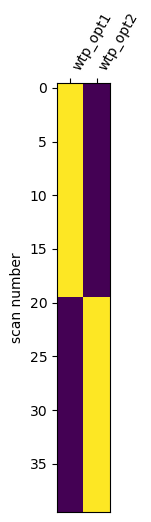

In [10]:
X = pd.DataFrame({
    'wtp_opt1': [1] * n_subs + [0] * n_subs,
    'wtp_opt2': [0] * n_subs + [1] * n_subs
})
#sub_effects = np.vstack((np.eye(n_subs),np.eye(n_subs)))
#X = pd.concat([X, pd.DataFrame(sub_effects, columns=sub_ids)], axis=1)
plot_design_matrix(X, rescale=False)

In [11]:
second_level_model_sc = SecondLevelModel().fit(zmaps_WTP, design_matrix=X)

#contrast_vector = np.array([0.5, 0.5] + [0] * len(sub_ids))
contrast_vector = np.array([0.5, 0.5])

WTP_WB_zmap = second_level_model_sc.compute_contrast(contrast_vector, output_type='stat')

In [12]:
WTP_thresholded_zmap, WTP_threshold = threshold_stats_img(WTP_WB_zmap, alpha=0.001, height_control='fpr')
print(f"Threshold: {WTP_threshold:.3f}")

Threshold: 3.291


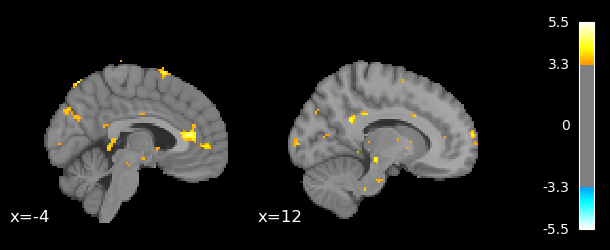

In [13]:
plot_stat_map(WTP_WB_zmap, threshold=WTP_threshold, black_bg=True, display_mode='x', cut_coords=[-4, 12],title='')

In [15]:
WTP_WB_zmap.to_filename(os.path.join('~/data/transfer', 'WTP_WB_zmap.nii'))